はじめに、Pythonのライブラリを起動する。

In [ ]:
# 必要なライブラリをインストール
!pip install -U statsmodels
!pip install japanize_matplotlib

In [ ]:
# プログラム2.1
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import filters as filt
from statsmodels.tsa.stattools import adfuller
# Colabでファイルを読み込むために、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#####
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
import japanize_matplotlib

続いて、データを読み込む。最初に読み込むデータは、内閣府が公表している名目GDP、実質GDP、GDPデフレータであり、これにより図2.1を作成できる。

In [ ]:
# プログラム2.2
# データの読み込み
gdp = pd.read_excel("/content/drive/My Drive/data_2.xlsx", sheet_name="GDP暦年(内閣府)", header=[0])
ngdp, rgdp, gdpdef = gdp.iloc[:, 1], gdp.iloc[:, 2], gdp.iloc[:, 3]
gdpdef_cal = ngdp / rgdp * 100
# データの出力
print(gdp)

      暦年     名目GDP     実質GDP  デフレーター
0   1994  510916.1  446522.3   114.4
1   1995  521613.5  458270.3   113.8
2   1996  535562.1  472631.9   113.3
3   1997  543545.4  477269.5   113.9
4   1998  536497.4  471206.6   113.9
5   1999  528069.9  469633.1   112.4
6   2000  535417.7  482616.8   110.9
7   2001  531653.9  484480.2   109.7
8   2002  524478.7  484683.5   108.2
9   2003  523968.6  492124.0   106.5
10  2004  529400.9  502882.4   105.3
11  2005  532515.6  511953.9   104.0
12  2006  535170.2  518979.7   103.1
13  2007  539281.7  526681.2   102.4
14  2008  527823.8  520233.1   101.5
15  2009  494938.4  490615.0   100.9
16  2010  505530.6  510720.0    99.0
17  2011  497448.9  510841.6    97.4
18  2012  500474.7  517864.4    96.6
19  2013  508700.6  528248.1    96.3
20  2014  518811.0  529812.8    97.9
21  2015  538032.3  538081.2   100.0
22  2016  544364.6  542137.4   100.4
23  2017  553073.0  551220.0   100.3
24  2018  556189.6  554300.5   100.3
25  2019  559826.7  554374.1   101.0
2

Text(0, 0.5, '2015年=100')

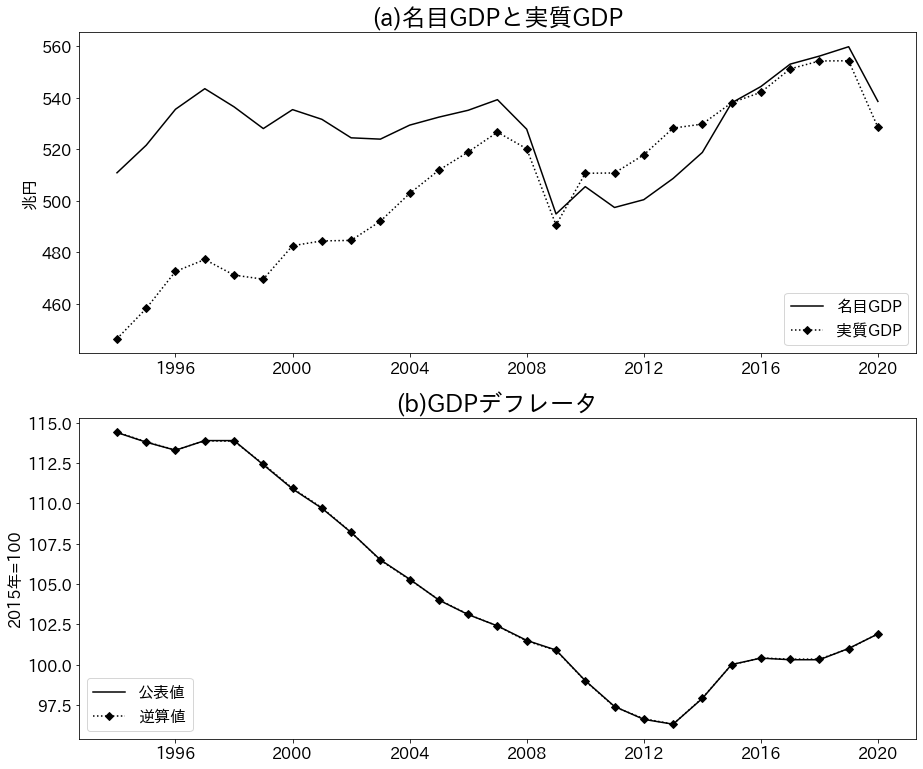

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
dti = pd.date_range("1994", periods=len(gdp), freq="YS")

ax1.set_title("(a)名目GDPと実質GDP", fontsize=24)
ax1.plot(dti, ngdp / 1000, label="名目GDP", color="black")
ax1.plot(dti, rgdp / 1000, label="実質GDP", color="black", linestyle = "dotted", marker="D")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("兆円", fontsize=16)
ax2.set_title("(b)GDPデフレータ", fontsize=24)
ax2.plot(dti, gdpdef, label="公表値", color="black")
ax2.plot(dti, gdpdef_cal, label="逆算値", color="black", linestyle = "dotted", marker="D")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("2015年=100", fontsize=16)

実質GDPの成長率について、変化率で計算する場合と対数近似の変化率で計算する場合を比較すると、図2.2を作成できる。

In [ ]:
# プログラム2.3
# 変化率と対数近似の変化率
rch = (rgdp[1:].to_numpy() / rgdp[:-1].to_numpy() - 1) * 100
lch = (np.log(rgdp[1:].to_numpy()) - np.log(rgdp[:-1].to_numpy())) * 100

Text(0, 0.5, '％')

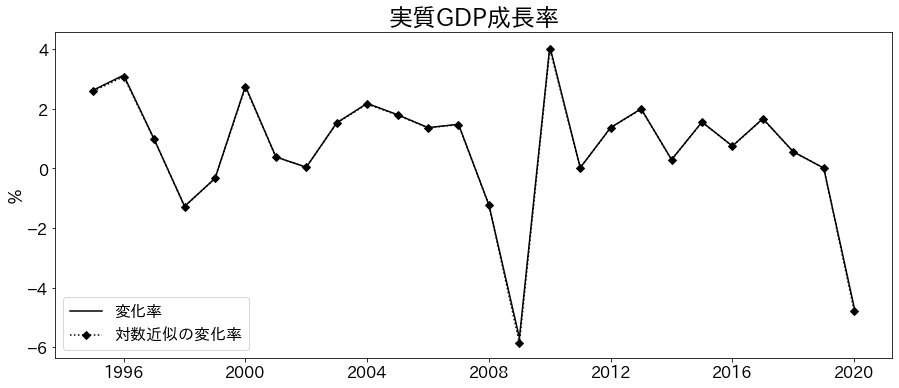

In [ ]:
#####
# グラフの描画
plt.title("実質GDP成長率", fontsize=24)
plt.plot(dti[1:], rch, label="変化率", color="black")
plt.plot(dti[1:], lch, label="対数近似の変化率", color="black", linestyle="dotted", marker="D")
plt.legend(loc="lower left", fontsize=16)
plt.tick_params(labelsize=16)
plt.ylabel("％", fontsize=16)

実質GDPの四半期原系列のデータを読み込む。図2.3に示した前年同期比、後方移動平均、中心化移動平均は、以下のコードで計算できる。

In [ ]:
# プログラム2.4
# 季節調整と移動平均
# データの読み込み
qgdp = pd.read_excel("/content/drive/My Drive/data_2.xlsx", sheet_name="GDP四半期原計数(内閣府)", header=[0])
qdti = pd.date_range("1994-01-01", periods=len(qgdp), freq="QS")
rqgdp = qgdp.iloc[:, 2]

# 前年同期比
qrch = (rqgdp[4:].to_numpy() / rqgdp[:-4].to_numpy() - 1) * 100
qlch = (np.log(rqgdp[4:].to_numpy()) - np.log(rqgdp[:-4].to_numpy())) * 100

# 後方移動平均・中心化移動平均
qqlch = (np.log(rqgdp[1:].to_numpy()) - np.log(rqgdp[:-1].to_numpy())) * 400
BMA_qqlch = (pd.DataFrame(qqlch)).rolling(window=4, center=False).mean()
CMA_qqlch = (
    (pd.DataFrame(qqlch)).rolling(window=4, center=False).mean().shift(-1)
    + (pd.DataFrame(qqlch)).rolling(window=4, center=False).mean().shift(-2)
) / 2

Text(0, 0.5, '％')

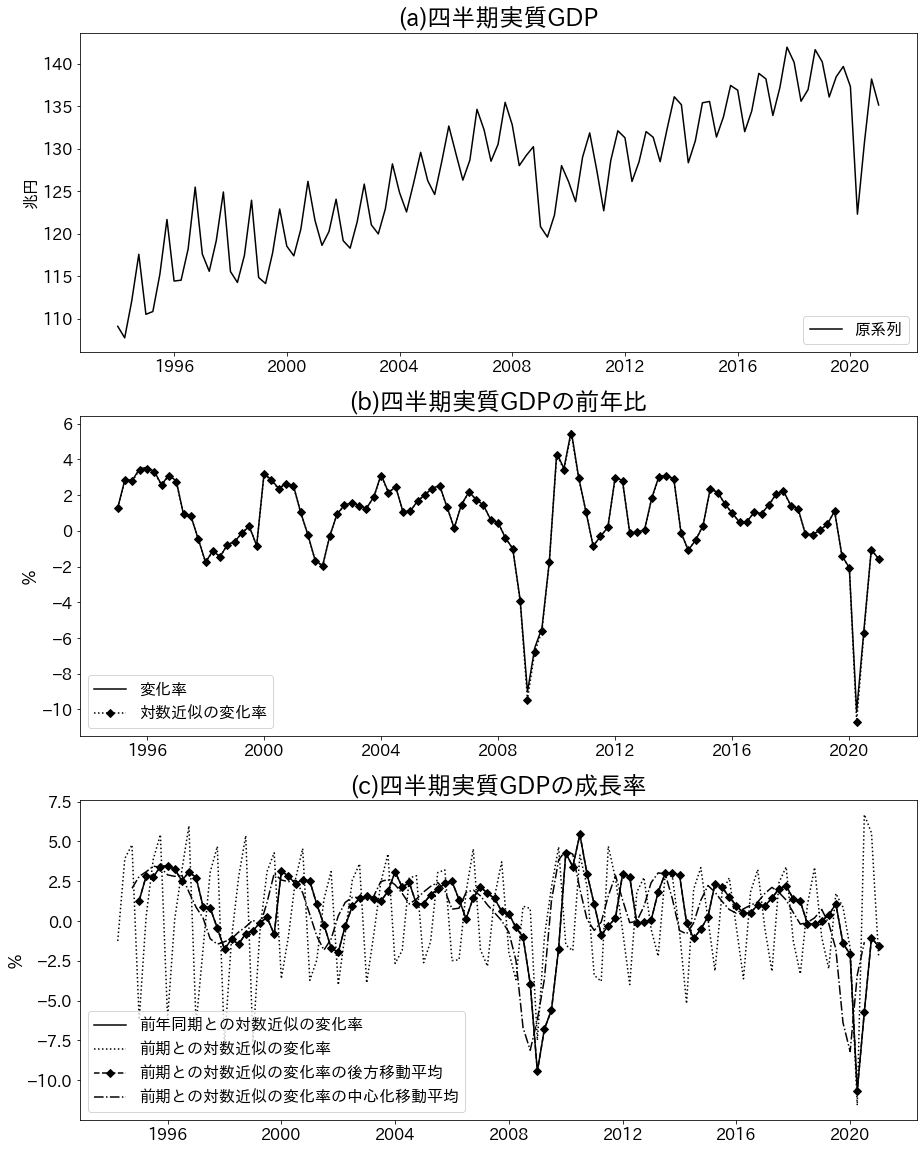

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)四半期実質GDP", fontsize=24)
ax1.plot(qdti, rqgdp / 1000, label="原系列", color="black")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("兆円", fontsize=16)
# 前年同期比
ax2.set_title("(b)四半期実質GDPの前年比", fontsize=24)
ax2.plot(qdti[4:], qrch, label="変化率", color="black")
ax2.plot(qdti[4:], qlch, label="対数近似の変化率", color="black", linestyle="dotted", marker="D")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("％", fontsize=16)
# 後方4四半期移動平均・中心4四半期移動平均
ax3.set_title("(c)四半期実質GDPの成長率", fontsize=24)
ax3.plot(qdti[4:], qlch, label="前年同期との対数近似の変化率", color="black")
ax3.plot(
    qdti[1:],
    (np.log(rqgdp[1:].to_numpy()) - np.log(rqgdp[:-1].to_numpy())) * 100,
    label="前期との対数近似の変化率",
    color="black",
    linestyle="dotted",
)
ax3.plot(qdti[1:], BMA_qqlch.to_numpy(), label="前期との対数近似の変化率の後方移動平均", color="black", linestyle="dashed", marker="D")
ax3.plot(qdti[1:], CMA_qqlch.to_numpy(), label="前期との対数近似の変化率の中心化移動平均", color="black", linestyle="dashdot")
ax3.legend(loc="lower left", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_ylabel("％", fontsize=16)

図2.4に示したHPフィルタによるディトレンドは、以下のコードで計算できる。なお、今回は対象となる変数が実質GDPの季節調整済み四半期系列であるため、表2.1に基づき、コードでλ=1,600としている。

In [ ]:
# プログラム2.5
# データの読み込み
qsagdp = pd.read_excel("/content/drive/My Drive/data_2.xlsx", sheet_name="GDP四半期季節調整済(内閣府)", header=[0])
rqsagdp = qsagdp.iloc[:, 2]
gap = qsagdp.iloc[:, 4]

# HPフィルタ(調整パラメータ=1600)を計算
hp = filt.hp_filter.hpfilter(np.log(rqsagdp), lamb=1600)
hp_cycle, hp_trend = pd.DataFrame(hp[0]), pd.DataFrame(hp[1])

Text(0, 0.5, '％')

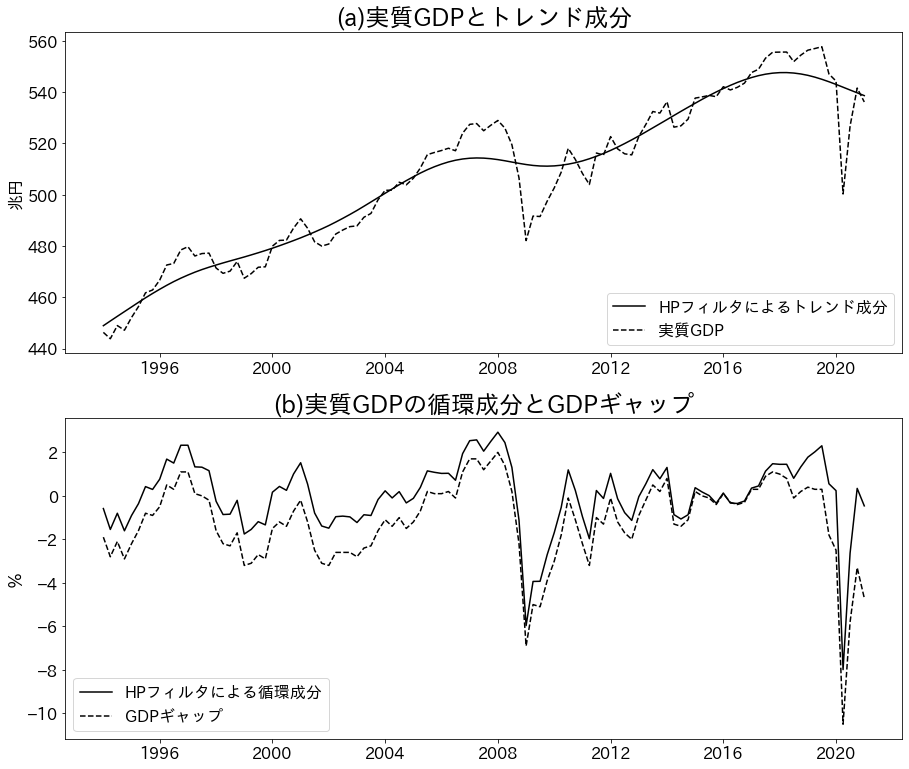

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)実質GDPとトレンド成分", fontsize=24)
ax1.plot(qdti, (np.exp(hp_trend) / 1000).to_numpy(), label="HPフィルタによるトレンド成分", color="black")
ax1.plot(qdti, rqsagdp / 1000, label="実質GDP", color="black", linestyle="dashed")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("兆円", fontsize=16)
ax2.set_title("(b)実質GDPの循環成分とGDPギャップ", fontsize=24)
ax2.plot(qdti, (hp_cycle.to_numpy()) * 100, label="HPフィルタによる循環成分", color="black")
ax2.plot(qdti, gap, label="GDPギャップ", color="black", linestyle="dashed")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("％", fontsize=16)

表2.3の単位根検定（ADF検定）は、以下のコードで計算できる。DF回帰式の定式化は"regression"において行っており、"n"は定数項も線形トレンドもない場合、"c"は定数項のみある場合、"ct"は定数項と線形トレンドがある場合である。また、ラグ次数の選択規準は"autolag"において設定できる。なお、ここで表示される臨界値は有限標本の修正により表2.2の値とは必ずしも一致しない。

In [ ]:
# プログラム2.6
# 単位根検定
# GDPギャップについてADF検定を実施
adf = adfuller(gap, regression="n", autolag="AIC")
print("[GDPギャップの単位根検定]")
print(f"ADF検定統計量: {adf[0]}")
print(f"p値: {adf[1]}")
print(f"臨界値: {adf[4]}")

# 実質GDPについてADF検定を実施
adf = adfuller(np.log(rqsagdp), regression="ct", autolag="AIC")
print("[四半期実質GDPの単位根検定]")
print(f"ADF検定統計量: {adf[0]}")
print(f"p値: {adf[1]}")
print(f"臨界値: {adf[4]}")

# 実質GDPの1階階差についてADF検定を実施
adf = adfuller(
    np.log(rqsagdp[1:].to_numpy()) - np.log(rqsagdp[:-1].to_numpy()),
    regression="c",
    autolag="AIC",
)
print("[四半期実質GDPの1階階差の単位根検定]")
print(f"ADF検定統計量: {adf[0]}")
print(f"p値: {adf[1]}")
print(f"臨界値: {adf[4]}")

[GDPギャップの単位根検定]
ADF検定統計量: -2.8675719712386725
p値: 0.004050069464733377
臨界値: {'1%': -2.5867528086419753, '5%': -1.9437507457260073, '10%': -1.6145732877356094}
[四半期実質GDPの単位根検定]
ADF検定統計量: -3.1660517629850413
p値: 0.09138099162936442
臨界値: {'1%': -4.045138739362648, '5%': -3.45195256255398, '10%': -3.1513450121932634}
[四半期実質GDPの1階階差の単位根検定]
ADF検定統計量: -10.944428837618332
p値: 9.122844796763975e-20
臨界値: {'1%': -3.492995948509562, '5%': -2.888954648057252, '10%': -2.58139291903223}


表2.5のBN分解によるディトレンドは、以下のコードで計算できる。なお、コードの"L"の値を変えることで階差系列のARモデルのラグ次数を変更することができる。

In [ ]:
# プログラム2.7
# BN分解
dgdp = pd.DataFrame(np.log(rqsagdp)[1:].to_numpy() - np.log(rqsagdp)[:-1].to_numpy())
ssize = len(dgdp)

L = 4  # ARモデルのラグ次数（4四半期）
y = pd.DataFrame(dgdp[(L - 1) + 1 : ssize])
x = pd.DataFrame()
for ll in range(1, L + 1):
    temp = pd.DataFrame(dgdp[L - ll : ssize + L - ll - (L - 1) - 1].to_numpy())
    x = pd.concat([x, temp], axis=1)

# ARモデルの推定
model = LinearRegression()
model.fit(x, y)
bmat = np.zeros((L, L))
bmat[0, :] = model.coef_
for i in range(1, L):
    bmat[i, i - 1] = 1
cvec, dvec = np.zeros((1, L)), np.zeros((1, L))
cvec[:, 0] = 1
dvec[:, 0] = (model.intercept_) / (1 - np.sum(model.coef_))
i_mat = np.eye(L)

delta_y = np.zeros([ssize + 1, L])
bn_trend, bn_cycle = np.zeros(ssize + 1), np.zeros(ssize + 1)
for i in range(L, ssize + 1):
    temp1 = dgdp[i - L : i].to_numpy()
    temp2 = temp1[::-1, :]
    delta_y[i] = temp2.reshape(L)
    # BN分解のトレンド成分
    bn_trend[i] = cvec @ (
        bmat @ (np.linalg.inv(i_mat - bmat)) @ (delta_y[i] - dvec).T
        + np.log(rqsagdp)[i]
    )
    # BN分解の循環成分
    bn_cycle[i] = -cvec @ bmat @ np.linalg.inv(i_mat - bmat) @ (delta_y[i] - dvec).T

Text(0, 0.5, '％')

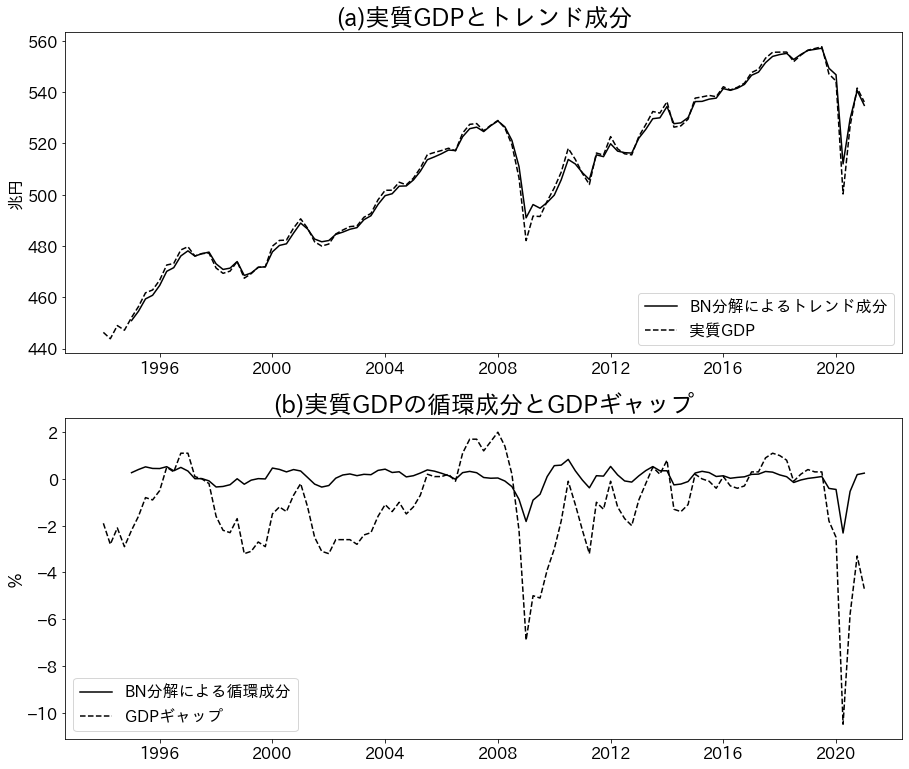

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)実質GDPとトレンド成分", fontsize=24)
ax1.plot(qdti[L:], np.exp(bn_trend)[L:] / 1000, label="BN分解によるトレンド成分", color="black")
ax1.plot(qdti, rqsagdp / 1000, label="実質GDP", color="black", linestyle="dashed")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("兆円", fontsize=16)
ax2.set_title("(b)実質GDPの循環成分とGDPギャップ", fontsize=24)
ax2.plot(qdti[L:], (bn_cycle[L:]) * 100, label="BN分解による循環成分", color="black")
ax2.plot(qdti, gap, label="GDPギャップ", color="black", linestyle="dashed")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("％", fontsize=16)

図2.6のUCモデルによるディトレンドは、以下のコードで計算できる。今回はトレンド成分をドリフト付きランダムウォークとしているため"rwdrift"としているが、ほかにも"ntrend"(トレンド項なし)や"rwalk"(ランダムウォーク)などを選択できる。また、"autoregressive"の値を変えることで循環成分のラグ次数を変更できる。

In [ ]:
# プログラム2.8
# UCモデル
mod_ucarima = sm.tsa.UnobservedComponents(np.log(rqsagdp), "rwdrift", autoregressive=2)
res_ucarima = mod_ucarima.fit(method="powell", disp=False)

Text(0, 0.5, '％')

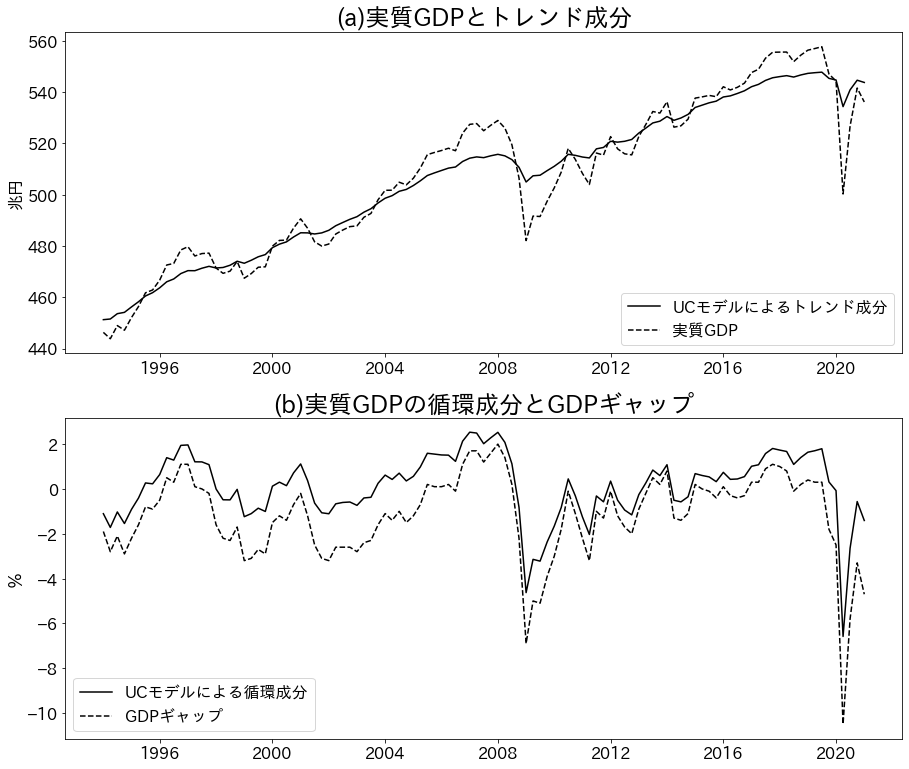

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)実質GDPとトレンド成分", fontsize=24)
ax1.plot(qdti, np.exp(res_ucarima.level.smoothed) / 1000, label="UCモデルによるトレンド成分", color="black")
ax1.plot(qdti, rqsagdp / 1000, label="実質GDP", color="black", linestyle="dashed")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("兆円", fontsize=16)
ax2.set_title("(b)実質GDPの循環成分とGDPギャップ", fontsize=24)
ax2.plot(qdti, (np.log(rqsagdp) - res_ucarima.level.smoothed) * 100, label="UCモデルによる循環成分", color="black")
ax2.plot(qdti, gap, label="GDPギャップ", color="black", linestyle="dashed")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("％", fontsize=16)